In [ ]:
!pip install torch

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_data():
  train_dataset = FashionMNIST(root='/content/drive/MyDrive', train=True, download=True, transform=transform)
  test_dataset = FashionMNIST(root='/content/drive/MyDrive', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

  return train_loader, test_loader

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# Define ResNet101 model using the blocks
class ResNet101(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet101, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Create ResNet101 model
resnet101 = ResNet101(BasicBlock, [3, 4, 23, 3])

In [ ]:
def train_model(model, trainloader, testloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.001)

  resnet101.to(device)

  num_epochs = 10

  for epoch in range(num_epochs):
    running_loss = 0.0

    for images, labels in trainloader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = resnet101(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(trainloader)}")

  print("Finished Training.")

  resnet101.eval()

  predicted_labels = []
  true_labels = []
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      outputs = resnet101(images)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      predicted_labels.extend(predicted.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

  conf_matrix = confusion_matrix(true_labels, predicted_labels)

  cm = confusion_matrix(true_labels, predicted_labels)
  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.tight_layout()
  plt.show()

  f1 = f1_score(true_labels, predicted_labels, average='weighted')
  print(f"F1 Score: {f1}")

  accuracy = correct / total
  print(f"Accuracy on the test set: {100 * accuracy:.2f}%")

In [ ]:
def main():
  train_loader, test_loader = load_data()
  resnet101 = ResNet101(BasicBlock, [3, 4, 23, 3], num_classes=10)
  train_model(resnet101, train_loader, test_loader)

Epoch 1/1 - Loss: 0.23798012026925203
Finished Training.


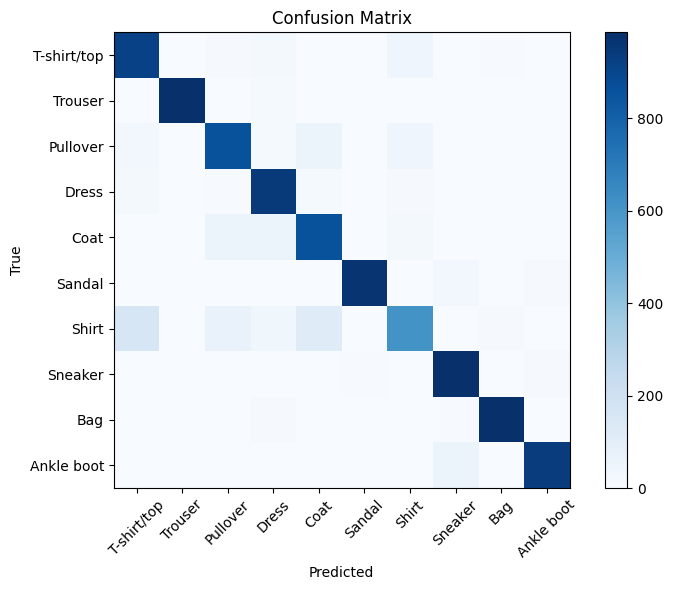

F1 Score: 0.9012357837847667
Accuracy on the test set: 90.34%


In [ ]:
if __name__ == "__main__":
  main()